## learning-AI : deep learning application (61357002)
### assignment :  HAR DSADS classification using LSTM with transfer learning (DL)

**HAR DSADS 데이터를 순환 데이터로 만들어 LSTM 방식의 classification, 전이 학습을 사용**

<br>

- **임규연 (lky473736)**
- 2024.09.24. ~ 2024.09.25.에 문서 작성
- **dataset** : ```../data/DSA_features.csv```
- **Reference** 
    - Generalizable Low-Resource Activity Recognition with Diverse and Discriminative Representation Learning (Xin Qin... / https://arxiv.org/abs/2306.04641)
    - https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko
    - https://velog.io/@xuio/Transfer-Learning%EA%B3%BC-Fine-Tuning
    - https://ratsgo.github.io/nlpbook/docs/introduction/transfer/
    - https://www.lgcns.com/blog/cns-tech/ai-data/11934/

-----

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HAR DSADS를 classification할 수 있는 예제인 ```Pre-trained_model.ipynb```(https://github.com/MyungKyuYi/AI-class/blob/main/Pre-trained_model.ipynb) 을 수정 및 내용을 추가한다. 이때, transfer learning을 도입하여 학습을 진행한다. 목차는 아래와 같다.

- **개요 : 전이학습에 대한 이해 및 classification strategy 세우기**
- **1. 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성**
- **2. RA model 구축 및 저장**
- **3. LA model 구축 및 저장**
- **4. transfer learning - LA model을 base로 둔 RA 기준의 remodeling**
- **5. transfer learning - RA model을 base로 둔 LA 기준의 remodeling**

In [425]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [426]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


-----


### 개요 : 전이학습에 대한 이해 및 classification strategy 세우기

<img src="./a_lot_of_mice.png" width="500px">

전이학습을 이해하기 위한 간단한 예시를 들자면, 내가 **만약 다람쥐와 땃쥐 사진을 구분하는 2D-CNN classification model을 만든다고 가정하자.** 기존처럼 feature extraction을 위해 convolution layer 배치하고, pooling 상황에 맞게 두고, overfitting을 막기 위해 dropout이나 l2 규제 layer에 씌우는 등의 메소드를 사용하여 modeling할 것이다. 그때 (갑자기) Google에서 다람쥐뿐만이 아닌, 각종 쥐 사진을 분류 가능한 classification 모델을 배포한다고 한다! **Google의 선진 기술을 체험해보고 싶은 개발자 개미들은 당연히 모델을 개조하여 자신만의 모델을 구성하고 싶어할 것이다. (물론 기업 입장에서는 더욱) 이때 필요한 기술이 전이학습이다.** 

<img src="https://blog.kakaocdn.net/dn/cAmFFd/btq4EdHvIvZ/cxHcykXW4KaSLkjC1duDok/img.png" width="500px">

**전이학습은 현재 해결해야 할 주제와 비슷한 주제를 이미 해결한 기존 모델을 이용 및 개조하여 더욱 성능 좋은 모델을 만드는 과정**이라고 볼 수 있다. 이전 예시에서, 나는 다람쥐와 땃쥐를 구분하는 모델을 구축하고 싶었다. 이때 Google은 각종 쥐를 분류하는 모델을 만들었고, 내가 당면한 문제와 Google이 제시한 문제는 매우 비슷하다. 따라서 나는 Google의 쥐 분류 모델을 base로 삼아서 modeling하면 되지 않겠는가? 위 figure에서 나와있듯이, A는 이미 모델링이 완료된 것이며, B를 해결하기 위해 A를 구성하는 모델을 일부 재사용하는 것이다.

전이학습의 핵심은 **이미 학습된 모델의 가중치를 재사용하여 새로운 문제를 해결하는 데 필요한 시간과 자원을 절감**하는 것이다. 특히 **feature extraction** 부분은 기본적으로 이미지에서 유용한 특징들을 찾아내는 과정인데, 이를 새로 구축하는 것보다는 **이미 잘 훈련된 모델의 하위 계층**을 그대로 가져와 사용하는 것이 매우 효율적이라는 것이다. 예를 들어, Google의 쥐 분류 모델에서 **convolutional layer와 pooling layer**는 다양한 쥐 이미지로부터 중요한 시각적 특징들을 잘 추출할 수 있게 이미 학습된 상태이다. 따라서 우리는 이러한 하위 계층들을 그대로 두고, **마지막 분류 계층 (Dense layer로 구성되었을 것이다.)** 만 우리의 문제에 맞게 조정하는 방식으로 새로운 모델을 빠르고 효과적으로 구축할 수 있다.

이러한 방식은 특히 **데이터가 부족할 때** 효과적이다. 만약 우리가 다람쥐와 땃쥐 이미지를 충분히 확보하지 못한 상태에서 모델을 처음부터 끝까지 학습시키려 한다면, 충분히 일반화된 모델을 만들기 어려울 수 있다. 하지만 전이학습을 활용하면 **이미 대규모 데이터셋에서 학습된 모델의 지식을 활용할 수 있기 때문에 상대적으로 적은 데이터로도 좋은 성능을 얻을 수 있다.**

본 문서에서는 이러한 전이학습을 예제로 구현한 ```./reference/Pre-trained_model.ipynb```를 가동시켜보고, 기존 문서에서 내용을 수정 및 보완, 추가하여 본다. 


------

### 1. 간단한 탐색적 데이터 분석 및 데이터 전처리 수행, 순환 데이터로 구성
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- 순환 데이터로 구성하기 위하여 split_sequence를 빈도 기준으로 한다.

In [427]:
# 파일 읽기

df = pd.read_csv("../../data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [428]:
# data info, describe

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
count,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,...,9120.000000,9.120000e+03,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9.120000e+03,9120.000000,9120.000000
mean,7.765766,14.625536,3.602974,17.807013,2.454290,0.305587,-0.811036,1.801847,-3.704204,2.049747,...,0.111347,1.818862e-02,0.105897,-0.055440,0.064504,0.169687,-0.052866,7.624694e-03,0.059342,-0.089861
std,3.758022,11.823448,5.622855,45.188787,3.432895,0.768360,2.201692,4.177165,3.982579,3.908675,...,0.362373,2.382393e-02,0.083518,0.526959,0.346660,0.360190,0.359712,1.903445e-02,0.064059,0.619636
min,-11.575660,-4.758700,-99.715000,0.000135,0.011633,-7.826631,-9.782885,-9.703600,-49.941000,0.000141,...,-0.901760,3.044156e-07,0.000552,-3.693948,-0.912397,-0.910830,-1.126000,2.960874e-07,0.000544,-5.111532
25%,8.374161,9.523200,0.000000,0.036855,0.191977,-0.161535,-1.134192,0.172375,-4.837875,0.012121,...,-0.111835,5.683172e-04,0.023839,-0.343123,-0.156271,-0.035821,-0.326125,2.227543e-04,0.014925,-0.402781
50%,9.186328,12.549500,5.757900,2.241468,1.497153,0.275042,-0.375678,1.571750,-2.470150,0.737663,...,0.184470,1.078612e-02,0.103856,-0.075786,0.086285,0.210825,-0.040447,1.813539e-03,0.042586,-0.092036
75%,9.515573,15.843250,7.649075,6.680571,2.584680,0.845410,0.127612,3.005450,-1.279725,1.900426,...,0.315962,2.740661e-02,0.165549,0.177076,0.295415,0.422270,0.206933,6.927870e-03,0.083234,0.228493
max,10.713139,93.694000,9.749000,392.898630,19.821671,9.070164,7.051530,41.013000,2.656400,54.332000,...,0.969020,3.041940e-01,0.551538,5.035185,1.020691,1.042600,0.999440,2.790198e-01,0.528223,3.560828


In [429]:
# 결측치 처리

print (df.isnull().sum())
df = df.dropna()
print ()
print (df.isnull().sum())

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64


In [430]:
# attribute가 무엇으로 구성되어 있는지 확인

print (df.columns)

'''
    attribute가 무려 271개나 있다. (activity 제외 / activity가 여기서 target값이 되겠다)
'''

Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_std', 'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max',
       'LL_zmag_min', 'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity',
       'people'],
      dtype='object', length=272)


'\n    attribute가 무려 271개나 있다. (activity 제외 / activity가 여기서 target값이 되겠다)\n'

In [431]:
# target값인 df['activity']의 각 클래스별 갯수 확인 

df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

'\n    모든 class가 480개로 빈도수가 동일하기 때문에 클래스 편향이 일어나지 않을 것이다.\n'

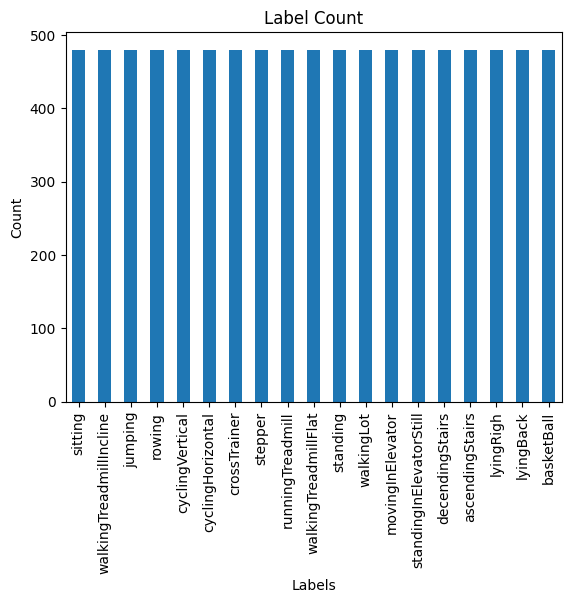

In [432]:
# countplot

import pandas as pd
import matplotlib.pyplot as plt

# 레이블별 갯수 확인
label_counts = df['activity'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

'''
    모든 class가 480개로 빈도수가 동일하기 때문에 클래스 편향이 일어나지 않을 것이다.
'''

In [433]:
# filter 기능을 통하여 RA_와 LA_로 시작하는 이름의 attribute를 통하여 split

df_RA = df.filter(regex='RA_') 
df_LA = df.filter(regex='LA_') 

'''
    여기서 RA는 Right Arm, LA는 Left Arm을 의미하며,
    각각을 구분한 이유는, RA에 특화되어 있는 모델과 LA에 특화되어 있는 모델을 각각 만들어 전이학습하기 위해서이다.
'''

'\n    여기서 RA는 Right Arm, LA는 Left Arm을 의미하며,\n    각각을 구분한 이유는, RA에 특화되어 있는 모델과 LA에 특화되어 있는 모델을 각각 만들어 전이학습하기 위해서이다.\n'

In [434]:
# 첫번째 열에 target 추가

# df_RA.insert(3, 'activity', df['activity'])
df_RA.insert(0, 'activity', df['activity'])

# df_LA.insert(3, 'activity', df['activity'])
df_LA.insert(0, 'activity', df['activity'])

print (df_RA.head(2))
print ()
print (df_LA.head(2))

'''
    가장 첫번째 열에 activity가 추가되었다
'''

  activity  RA_xacc_mean  RA_xacc_max  RA_xacc_min  RA_xacc_var  RA_xacc_std  \
0  sitting      0.679134      0.75930      0.58542     0.001546     0.039324   
1  sitting      0.644964      0.73158      0.53064     0.001333     0.036508   

   RA_xacc_skew  RA_yacc_mean  RA_yacc_max  RA_yacc_min  ...  RA_ymag_min  \
0     -0.415694      5.713088       5.8483       5.5956  ...     -0.57428   
1      0.410625      5.795154       5.9546       5.6687  ...     -0.57398   

   RA_ymag_var  RA_ymag_std  RA_ymag_skew  RA_zmag_mean  RA_zmag_max  \
0     0.000012     0.003401      -0.05219     -0.211136     -0.18401   
1     0.000005     0.002216       0.22274     -0.206431     -0.18054   

   RA_zmag_min  RA_zmag_var  RA_zmag_std  RA_zmag_skew  
0     -0.24523     0.000044     0.006638     -1.153902  
1     -0.23624     0.000032     0.005660      0.458427  

[2 rows x 55 columns]

  activity  LA_xacc_mean  LA_xacc_max  LA_xacc_min  LA_xacc_var  LA_xacc_std  \
0  sitting      3.403317       3.48

'\n    가장 첫번째 열에 activity가 추가되었다\n'

In [435]:
print ("LA\n", df_LA['activity'].value_counts())
print ()
print ("RA\n",df_RA['activity'].value_counts())

'''
    activity에 각 활동명이 class로 되어 있어서, 이를 integer로 변경해야 하겠다.
    0-based class (int)로 구성하기 위해 label encoding을 진행한다
'''

LA
 activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

RA
 activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot       

'\n    activity에 각 활동명이 class로 되어 있어서, 이를 integer로 변경해야 하겠다.\n    0-based class (int)로 구성하기 위해 label encoding을 진행한다\n'

In [436]:
# target 값이 현재 문자열로 이루어져 있기 때문에 label encoding을 통하여 0-based로 된 class로 remapping

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])

label_encoder = LabelEncoder()
df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])

/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_11836/124429059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RA['activity'] = label_encoder.fit_transform(df_RA['activity'])
/var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_11836/124429059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LA['activity'] = label_encoder.fit_transform(df_LA['activity'])


In [437]:
# label encoding된 결과 확인

print ("LA\n", df_LA['activity'].value_counts())
print ()
print ("RA\n", df_RA['activity'].value_counts())

LA
 activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

RA
 activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64


In [438]:
# input, target split

# RA의 target을 activity로 설정함
df_RA_Y = df_RA['activity'] 
df_RA_X = df_RA.drop ('activity', axis=1)
print  (df_RA_X.head(10))

# LA의 target을 activity로 설정함
df_LA_Y = df_LA['activity']
df_LA_X=df_LA.drop('activity',axis=1)
print (df_LA_X.head(10))

   RA_xacc_mean  RA_xacc_max  RA_xacc_min  RA_xacc_var  RA_xacc_std  \
0      0.679134      0.75930      0.58542     0.001546     0.039324   
1      0.644964      0.73158      0.53064     0.001333     0.036508   
2      0.608212      0.67737      0.53546     0.000637     0.025244   
3      0.591138      0.71177      0.51524     0.001349     0.036731   
4      0.558168      0.67190      0.50535     0.000626     0.025020   
5      0.559089      0.62268      0.51006     0.000567     0.023811   
6      0.540004      0.59306      0.49022     0.000286     0.016898   
7      0.537077      0.59728      0.48991     0.000448     0.021171   
8      0.538192      0.61939      0.47966     0.001079     0.032846   
9      0.485706      0.53814      0.44280     0.000314     0.017713   

   RA_xacc_skew  RA_yacc_mean  RA_yacc_max  RA_yacc_min  RA_yacc_var  ...  \
0     -0.415694      5.713088       5.8483       5.5956     0.003779  ...   
1      0.410625      5.795154       5.9546       5.6687     0.00

In [439]:
# train, test, split

from sklearn.model_selection import train_test_split

X_train_RA, X_test_RA, y_train_RA, y_test_RA = train_test_split(df_RA_X, 
                                                    df_RA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

X_train_LA, X_test_LA, y_train_LA, y_test_LA = train_test_split(df_LA_X, 
                                                    df_LA_Y,
                                                    test_size = 0.25, 
                                                    random_state = 21)

print (X_train_RA.shape, X_test_RA.shape, y_train_RA.shape, y_test_RA.shape)
print (X_train_LA.shape, X_test_LA.shape, y_train_LA.shape, y_test_LA.shape)

(6840, 54) (2280, 54) (6840,) (2280,)
(6840, 54) (2280, 54) (6840,) (2280,)


In [440]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [441]:
# X_train_seq_RA, y_train_seq_RA, X_test_seq_RA, y_test_seq_RA 구성

# Merge train and test X/y data to apply sequence transformation function
y_train_array_RA = np.array(y_train_RA)
train_set_RA = np.c_[X_train_RA, y_train_array_RA]

y_test_array_RA = np.array(y_test_RA)
test_set_RA = np.c_[X_test_RA, y_test_array_RA]

n_step = 3  # window 사이즈는 3으로 한다
 
X_train_seq_RA, y_train_seq_RA = split_sequences(train_set_RA, n_step)
print(X_train_seq_RA.shape, y_train_seq_RA.shape)

X_test_seq_RA, y_test_seq_RA = split_sequences(test_set_RA, n_step)
print(X_test_seq_RA.shape, y_test_seq_RA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


In [442]:
# X_train_seq_LA, y_train_seq_LA, X_test_seq_LA, y_test_seq_LA 구성

# Merge train and test X/y data to apply sequence transformation function
y_train_array_LA = np.array(y_train_LA)
train_set_LA = np.c_[X_train_LA, y_train_array_LA]

y_test_array_LA = np.array(y_test_LA)
test_set_LA = np.c_[X_test_LA, y_test_array_LA]

n_step = 3 

X_train_seq_LA, y_train_seq_LA = split_sequences(train_set_LA, n_step)
print(X_train_seq_LA.shape, y_train_seq_LA.shape)

X_test_seq_LA, y_test_seq_LA = split_sequences(test_set_LA, n_step)
print(X_test_seq_LA.shape, y_test_seq_LA.shape)

(6838, 3, 54) (6838,)
(2278, 3, 54) (2278,)


In [443]:
# one hot encoding을 진행한다. (categorical crossentropy)

from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train_seq_RA = to_categorical(y_train_seq_RA)
print(y_train_seq_RA.shape)

y_test_seq_RA = to_categorical(y_test_seq_RA)
print(y_test_seq_RA.shape)

# Convert output variables to categorical for CNN
y_train_seq_LA = to_categorical(y_train_seq_LA)
print(y_train_seq_LA.shape)

y_test_seq_LA = to_categorical(y_test_seq_LA)
print(y_test_seq_LA.shape)

(6838, 19)
(2278, 19)
(6838, 19)
(2278, 19)



-----

### 2. RA model 구축 및 저장
- RA model을 먼저 구축하여 그에 대한 가중치 및 bias, parameter를 저장해놓는다.
- 추후 전이학습을 진행할 때 불러와 base model로 삼기 위해서다.
    - **RA model을 base로 하여 LA에 맞추기 (fine tuning하여)**

In [444]:
'''
    n_timesteps : window를 구성하는 records 수
    n_features : 열의 갯수 (feature 갯수)
    n_outputs : 총 결과 class 갯수
'''

# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train_seq_RA.shape[1], X_train_seq_RA.shape[2], y_train_seq_RA.shape[1]
print(n_timesteps, n_features, n_outputs)

3 54 19


In [445]:
'''
    LSTM -> dense modeling
'''

# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model_RA = Sequential()
model_RA.add(LSTM(units=128, input_shape = (n_timesteps, n_features)))
model_RA.add(Dense(128, activation='relu'))
model_RA.add(Dense(n_outputs, activation='softmax'))

# compile
model_RA.compile(optimizer='adam', 
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

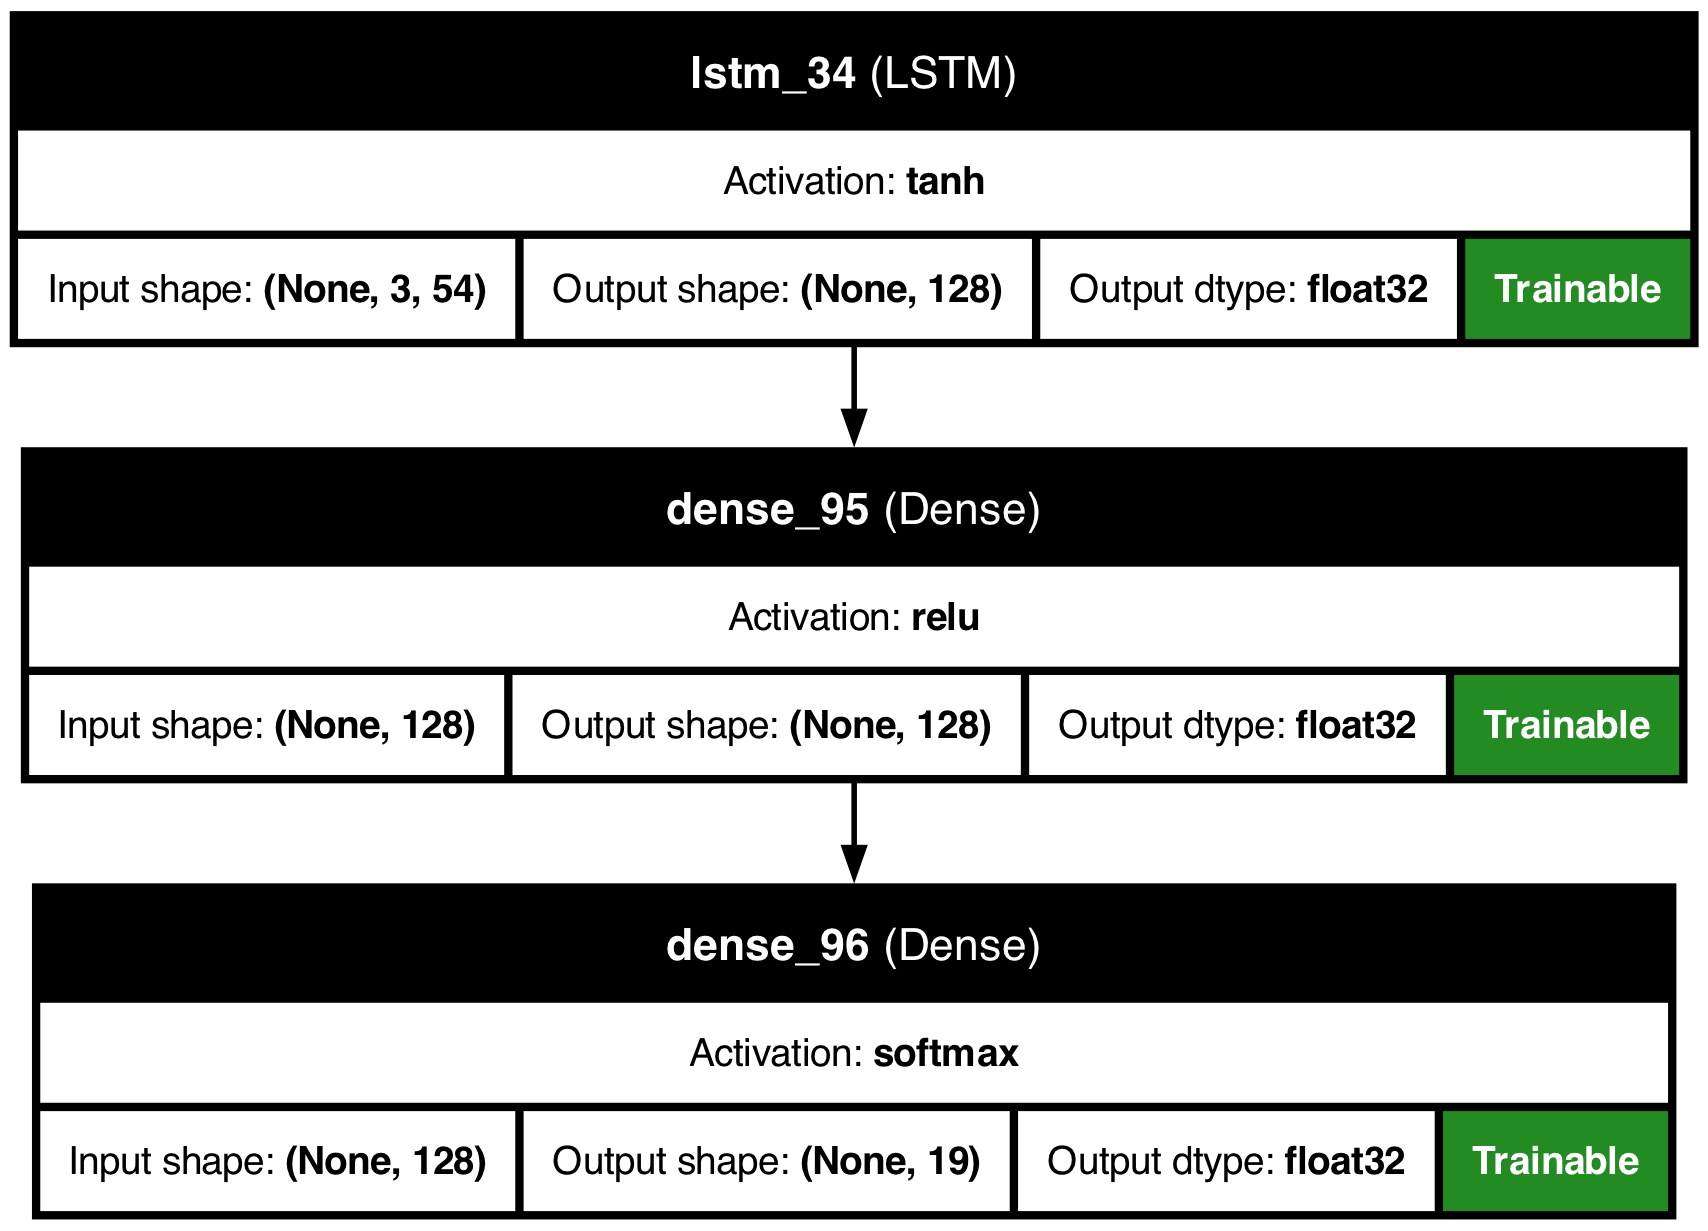

In [446]:
# 모델 시각화 

model_RA.summary()
keras.utils.plot_model(model_RA, show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True, 
                       show_shapes=True,
                       show_trainable=True)

In [447]:
# fit 

history_RA = model_RA.fit(X_train_seq_RA, 
                    y_train_seq_RA, 
                    epochs = 20, batch_size = 32, 
                    validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2220 - loss: 2.5129 - val_accuracy: 0.5731 - val_loss: 1.3451
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6150 - loss: 1.1706 - val_accuracy: 0.7456 - val_loss: 0.9597
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7717 - loss: 0.7834 - val_accuracy: 0.7836 - val_loss: 0.8060
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8220 - loss: 0.5965 - val_accuracy: 0.8173 - val_loss: 0.7171
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8451 - loss: 0.5270 - val_accuracy: 0.8304 - val_loss: 0.6700
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8766 - loss: 0.4089 - val_accuracy: 0.8465 - val_loss: 0.6553
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9031 - loss: 0.3387 - val_accuracy: 0.8596 - val_loss: 0.6066
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9182 - loss: 0.2984 - val_accuracy: 0.

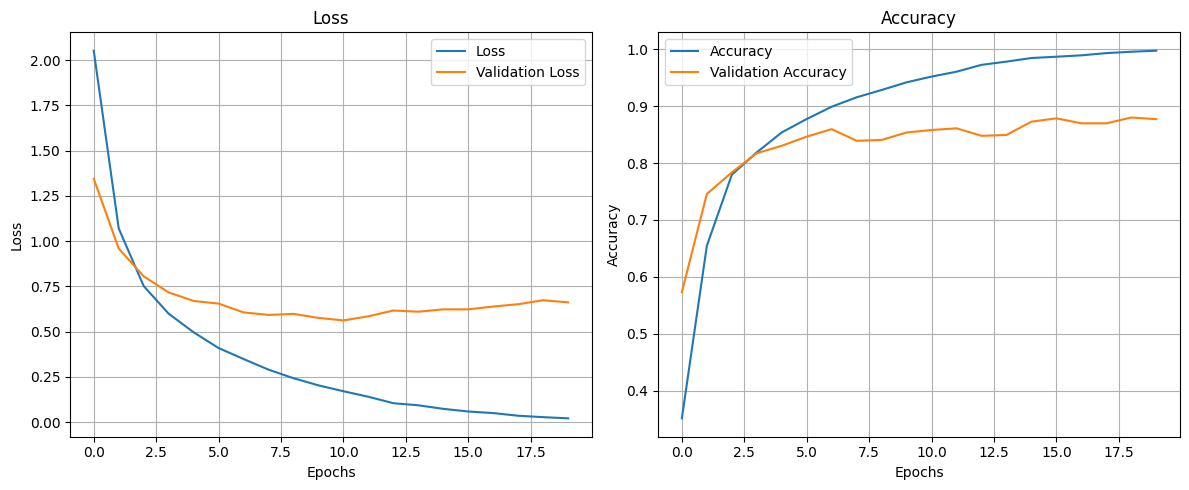

In [448]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history_RA)

In [449]:
# evaluate

print ("train score : ", model_RA.evaluate(X_train_seq_RA, y_train_seq_RA))
print ("test score : ", model_RA.evaluate(X_test_seq_RA, y_test_seq_RA))

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0206
train score :  [0.08124798536300659, 0.9853758215904236]
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8757 - loss: 0.6498
test score :  [0.6724498867988586, 0.8696224689483643]


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix


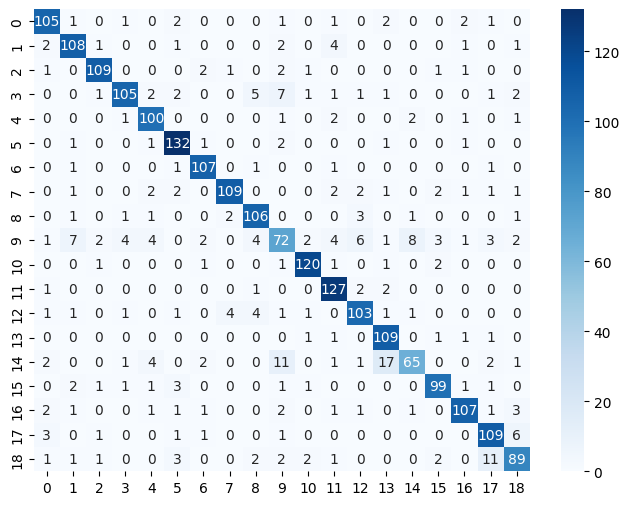

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       116
           1       0.86      0.90      0.88       120
           2       0.93      0.92      0.93       118
           3       0.91      0.81      0.86       129
           4       0.86      0.93      0.89       108
           5       0.89      0.95      0.92       139
           6       0.91      0.96      0.93       112
           7       0.94      0.88      0.91       124
           8       0.86      0.91      0.89       116
           9       0.68      0.57      0.62       126
          10       0.93      0.94      0.94       127
          11       0.86      0.95      0.91       133
          12       0.87      0.87      0.87       119
          13       0.80      0.96      0.87       114
          14       0.83      0.61      0.70       107
          15       0.90      0.89      0.90       111
          16       0.91      0.88      0.90       122
          17       0.83    

In [450]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg=np.argmax(y_test_seq_RA, axis=1)
Y_pred = np.argmax(model_RA.predict(X_test_seq_RA),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

In [451]:
# base loss, base accuracy 구하고 저장

base_loss,base_accuracy = model_RA.evaluate(X_test_seq_RA, y_test_seq_RA)

model_file_RA = './model/RA_model.h5'
  
tf.keras.models.save_model(model_RA, model_file_RA, include_optimizer=False)
print('model saved at ', model_file_RA)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)

score = base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8757 - loss: 0.6498


model saved at  ./model/RA_model.h5
Accuracy >86.962247
Base Loss >0.67



-----

### 3. LA model 구축 및 저장
- LA model을 구축하여 그에 대한 가중치 및 bias, parameter를 저장해놓는다.
- 추후 전이학습을 진행할 때 불러와 base model로 삼기 위해서다.
    - **LA model을 base로 하여 RA에 맞추기 (fine tuning하여)**

In [452]:
'''
    LSTM -> dense modeling
'''

# Build CNN model using keras. For model building suggestions, referenced:
# https://machinelearningmastery.com/deep-learning-models-for-human-activity-recognition/
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

# Sequential model type
model_LA = Sequential()
model_LA.add(LSTM(units=128, input_shape = (n_timesteps,n_features)))
model_LA.add(Dense(128, activation='relu'))
model_LA.add(Dense(n_outputs, activation='softmax'))

# compile
model_LA.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,659 (440.07 KB)

 Trainable params: 112,659 (440.07 KB)

 Non-trainable params: 0 (0.00 B)

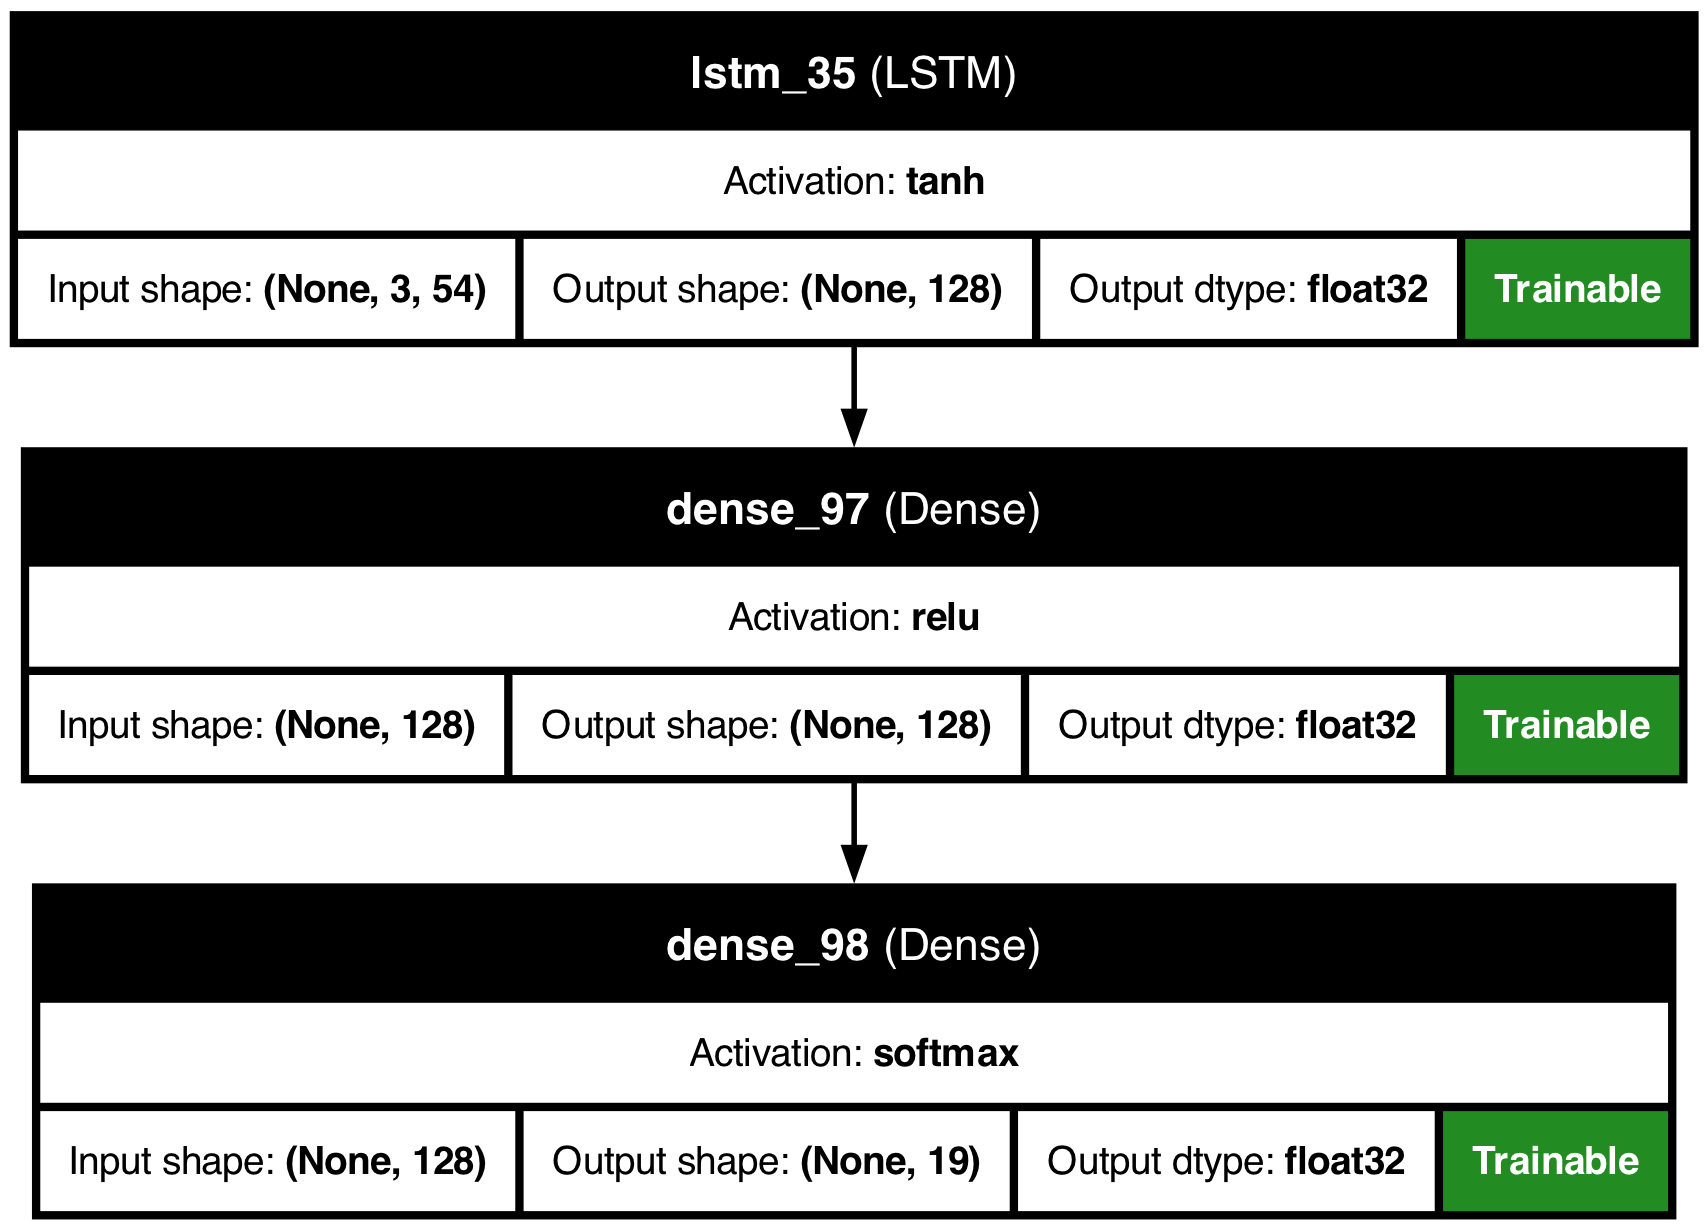

In [453]:
# 모델 시각화

model_LA.summary()
keras.utils.plot_model(model_LA, show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True, 
                       show_shapes=True,
                       show_trainable=True)

In [454]:
# fit 

history_LA = model_LA.fit(X_train_seq_LA, 
                    y_train_seq_LA, 
                    epochs = 20, batch_size = 32, 
                    validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2292 - loss: 2.4941 - val_accuracy: 0.5994 - val_loss: 1.2466
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6417 - loss: 1.0739 - val_accuracy: 0.7529 - val_loss: 0.8331
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7648 - loss: 0.7583 - val_accuracy: 0.7997 - val_loss: 0.6903
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8470 - loss: 0.5405 - val_accuracy: 0.8436 - val_loss: 0.6050
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8692 - loss: 0.4530 - val_accuracy: 0.8348 - val_loss: 0.6090
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8854 - loss: 0.3886 - val_accuracy: 0.8655 - val_loss: 0.5329
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9132 - loss: 0.3020 - val_accuracy: 0.8304 - val_loss: 0.6050
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9262 - loss: 0.2675 - val_accuracy: 0.

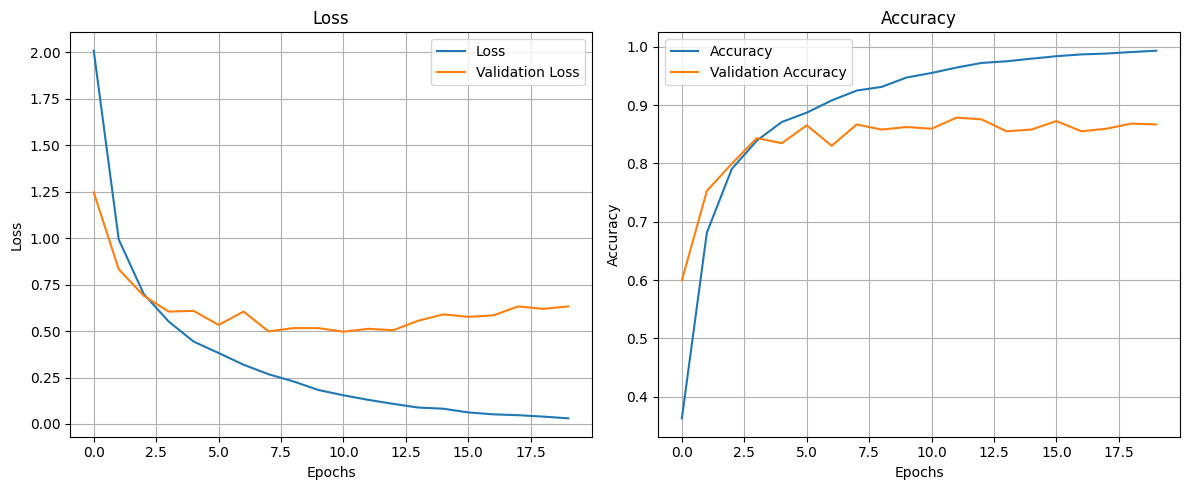

In [455]:
# loss와 validation loss, acc와 validation acc 시각화

draw_history(history_LA)

In [456]:
# evaluate

print ("train score : ", model_LA.evaluate(X_train_seq_LA, y_train_seq_LA))
print ("test score : ", model_LA.evaluate(X_test_seq_LA, y_test_seq_LA))

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0268
train score :  [0.08396867662668228, 0.9833284616470337]
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.5373
test score :  [0.5674659609794617, 0.887620747089386]


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix


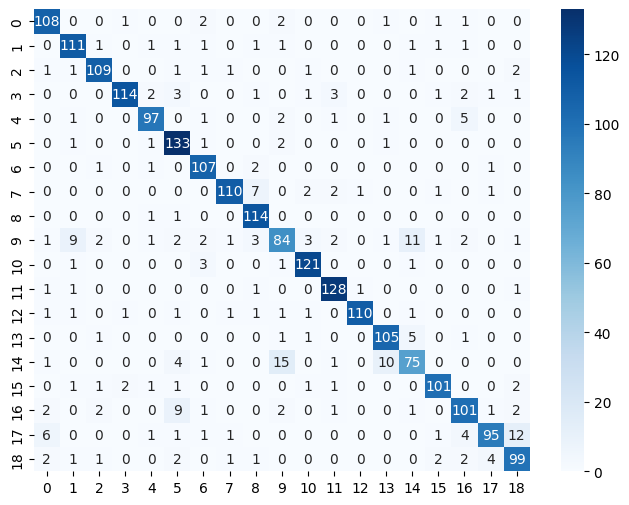

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       116
           1       0.87      0.93      0.90       120
           2       0.92      0.92      0.92       118
           3       0.97      0.88      0.92       129
           4       0.92      0.90      0.91       108
           5       0.84      0.96      0.89       139
           6       0.88      0.96      0.92       112
           7       0.96      0.89      0.92       124
           8       0.87      0.98      0.92       116
           9       0.76      0.67      0.71       126
          10       0.92      0.95      0.94       127
          11       0.92      0.96      0.94       133
          12       0.98      0.92      0.95       119
          13       0.88      0.92      0.90       114
          14       0.78      0.70      0.74       107
          15       0.93      0.91      0.92       111
          16       0.85      0.83      0.84       122
          17       0.92    

In [457]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg=np.argmax(y_test_seq_LA, axis=1)
Y_pred = np.argmax(model_LA.predict(X_test_seq_LA),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

In [458]:
# base loss, base accuracy 구하고 저장

base_loss,base_accuracy = model_LA.evaluate(X_test_seq_LA, y_test_seq_LA)

model_file_LA = './model/LA_model.h5'
  
tf.keras.models.save_model(model_LA, model_file_LA, include_optimizer=False)
print('model saved at ', model_file_LA)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)

score = base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8959 - loss: 0.5373


model saved at  ./model/LA_model.h5
Accuracy >88.762075
Base Loss >0.57



-----

### 4. transfer learning - LA model을 base로 둔 RA 기준의 remodeling
아래와 같은 순서로 진행된다.

- **(1) LA (Left Arm) 모델 불러오기** : 사전 학습된 LA 모델을 로드한다.
  - `load_model()` 함수를 사용하여 기존 모델을 불러온다.

- **(2) Layer 동결 및 Fine-tuning 설정** : convolutional layers는 freezing하고, Dense layers만 재학습할 수 있도록 설정한다.
  - Convolutional layers 혹은 LSTM은 Left Arm과 Right Arm 간 공통 특징을 잡아내므로 고정한다.
  - Dense layers는 새로운 Right Arm 데이터에 맞춰 재학습하도록 설정한다.

- **(3) RA (Right Arm) 데이터셋을 적용한 출력 레이어 수정** : Left Arm 모델의 출력 레이어를 Right Arm 기준으로 변경한다.
  - 기존의 feature extraction 부분은 그대로 두고, 새로운 Dense 레이어를 추가한다.
  - Right Arm 데이터에 맞는 새로운 출력 레이어를 정의한다.

- **(4) RA 데이터로 모델 재학습** : Right Arm 데이터를 사용해 Fine-tuning을 진행하여 모델을 재학습한다.
  - Dense layers만 재학습하고 나머지 레이어는 기존 가중치를 그대로 사용한다.

In [459]:
# base 모델 로드 (LA_model.h5)

from tensorflow.keras.models import load_model

base_model = load_model(model_file_LA)

In [460]:
# base 모델을 학습시켰던 LA를 대입하여 평가해본다

base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

'''
    당연히 뛰어난 결과가 나오는 것이 인지상정이다. 왜냐면 이 데이터로 학습을 시켰으니깐
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8959 - loss: 0.5373


'\n    당연히 뛰어난 결과가 나오는 것이 인지상정이다. 왜냐면 이 데이터로 학습을 시켰으니깐\n'

In [461]:
# RA를 대입하여 평가해본다

base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

'''
    너무나도 당연한데, LA에 맞게끔 weight와 bias가 조정되어 있는 LA 모델에 RA 데이터셋을 대입하면 
    acc는 낮게, loss는 높게 구성될 수밖에 없는 것이다. 
    
    따라서 LA 모델에서 특정 layer를 freezing시키고, 나머지 Dense layer를 fine-tuning하여
    RA 데이터셋에 acc가 높게 구성될 수 있도록 해본다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2115 - loss: 6.3463


'\n    너무나도 당연한데, LA에 맞게끔 weight와 bias가 조정되어 있는 LA 모델에 RA 데이터셋을 대입하면 \n    acc는 낮게, loss는 높게 구성될 수밖에 없는 것이다. \n    \n    따라서 LA 모델에서 특정 layer를 freezing시키고, 나머지 Dense layer를 fine-tuning하여\n    RA 데이터셋에 acc가 높게 구성될 수 있도록 해본다.\n'

In [462]:
# 모든 convolutional layers을 동결 
# 목적 : CNN과 같은 feature selection은 기존의 패턴을 인식한 거니깐 추가적으로 가중치를 학습되지 않도록 하기 위해서임

base_model.layers[0].trainable = False  # lstm 층 동결

'''
    전이학습에서 가장 중요한 부분은 기존 모델의 가중치를 어느 정도까지 고정(freeze)하고, 어느 부분을 재학습(fine-tuning)할지 결정해야 함 
    LSTM과 같은 feature extraction에서는 Left Arm과 Right Arm 데이터 간의 공통적인 특징을 잡아낼 수 있기 때문에, 
    일반적으로 고정시키고 Dense layers만 재학습하는 경우가 많다
'''

'\n    전이학습에서 가장 중요한 부분은 기존 모델의 가중치를 어느 정도까지 고정(freeze)하고, 어느 부분을 재학습(fine-tuning)할지 결정해야 함 \n    LSTM과 같은 feature extraction에서는 Left Arm과 Right Arm 데이터 간의 공통적인 특징을 잡아낼 수 있기 때문에, \n    일반적으로 고정시키고 Dense layers만 재학습하는 경우가 많다\n'

In [463]:
# 기존 LA 모델에서 feature extraction은 가져온다
# -> dense layer를 삽입하여 새로운 RA 데이터셋에서도 가중치를 학습할 수 있도록 한다.
# -> 끝에 클래스 수만큼 노드를 배치하여 분류할 수 있도록 한다

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow as tf

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (non trainable)
x = Dense(64, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # RA 데이터셋에 맞는 출력 레이어

model_LA_transfer = Model(inputs=input_data, outputs=output)

# compile
model_LA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [464]:
# 시각화하여 layers 보여주기

display_layers = [(layer, layer.name, layer.trainable) for layer in model_LA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_61, built=True>",input_layer_61,True
1,"<LSTM name=lstm_35, built=True>",lstm_35,False
2,"<Dense name=dense_99, built=True>",dense_99,True
3,"<Dense name=dense_100, built=True>",dense_100,True


In [465]:
# fit

history_LA_transfer = model_LA_transfer.fit(X_train_seq_RA, y_train_seq_RA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2386 - loss: 2.5701 - val_accuracy: 0.4942 - val_loss: 1.6205
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5453 - loss: 1.5044 - val_accuracy: 0.5760 - val_loss: 1.3580
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6029 - loss: 1.2790 - val_accuracy: 0.6126 - val_loss: 1.2534
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6359 - loss: 1.1516 - val_accuracy: 0.6170 - val_loss: 1.1991
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6634 - loss: 1.0916 - val_accuracy: 0.6520 - val_loss: 1.1523
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6862 - loss: 1.0215 - val_accuracy: 0.6550 - val_loss: 1.1105
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6896 - loss: 0.9944 - val_accuracy: 0.6623 - val_loss: 1.0953
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7176 - loss: 0.9293 - val_accuracy: 0.

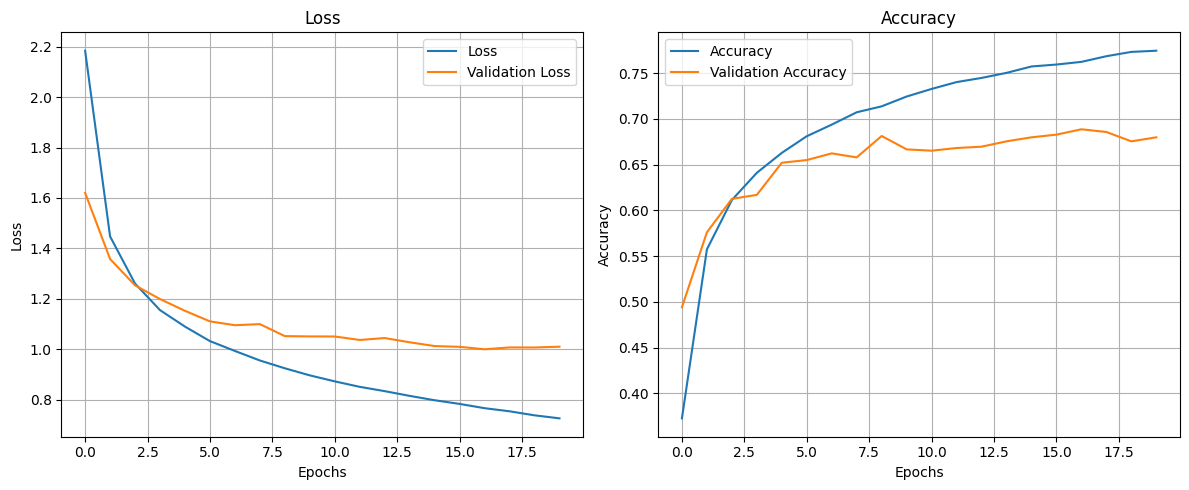

In [466]:
# loss와 validation loss, acc와 validation acc 시각화

draw_history(history_LA_transfer)

In [467]:
# evaluate

eval_transfer = model_LA_transfer.evaluate(X_test_seq_RA, y_test_seq_RA)

'''
    이전보다 좋지 못한 acc를 보이고 있으므로, 아래와 같은 방법을 생각할 수 있겠다.
    
    1) 모든 layer의 trainable을 True로 바꾸어서, LA에서 학습하였던 가중치를 RA에도 맞게끔 update해줘야 할 것 같다. 
    2) LSTM을 하나 더 추가하여 RA에 맞는 weight를 학습시킨다
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 1.0337


'\n    이전보다 좋지 못한 acc를 보이고 있으므로, 아래와 같은 방법을 생각할 수 있겠다.\n    \n    1) 모든 layer의 trainable을 True로 바꾸어서, LA에서 학습하였던 가중치를 RA에도 맞게끔 update해줘야 할 것 같다. \n    2) LSTM을 하나 더 추가하여 RA에 맞는 weight를 학습시킨다\n'

#### fine-tuning : (4-1) 모든 layer의 trainable을 True로 바꾸어 다시 학습을 진행

- 이러면 이전 모델의 가중치가 다시 RA에 맞춰지도록 train되는 것이다.
- 하지만 LA를 학습 후에 RA를 학습하는 것이기 때문에, RA에 모델이 맞추어져 이번에는 LA를 분류하지 못할 가능성이 있다. (추후 evaluate로 확인 예정)

In [468]:
# 이전에 model_LA에서의 layer 중 LSTM의 trainable을 False로 바꾼 것을 번복. 다시 True로 구성
# 구성 후 modeling

base_model.layers[0].trainable = True 

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (trainable)
x = Dense(64, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # RA 데이터셋에 맞는 출력 레이어

model_LA_transfer = Model(inputs=input_data, outputs=output)

# compile
model_LA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [469]:
# layers 시각화, trainable 시각화, model summary

model_LA_transfer.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in model_LA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 3, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,187 (403.07 KB)

 Trainable params: 103,187 (403.07 KB)

 Non-trainable params: 0 (0.00 B)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_62, built=True>",input_layer_62,True
1,"<LSTM name=lstm_35, built=True>",lstm_35,True
2,"<Dense name=dense_101, built=True>",dense_101,True
3,"<Dense name=dense_102, built=True>",dense_102,True


In [470]:
# fit

history_LA_transfer = model_LA_transfer.fit(X_train_seq_RA, y_train_seq_RA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3215 - loss: 2.2410 - val_accuracy: 0.7032 - val_loss: 1.0554
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7596 - loss: 0.8892 - val_accuracy: 0.8275 - val_loss: 0.7363
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8351 - loss: 0.6002 - val_accuracy: 0.8289 - val_loss: 0.6816
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8760 - loss: 0.4732 - val_accuracy: 0.8480 - val_loss: 0.6205
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8930 - loss: 0.3965 - val_accuracy: 0.8480 - val_loss: 0.5937
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9154 - loss: 0.3242 - val_accuracy: 0.8626 - val_loss: 0.5616
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9345 - loss: 0.2544 - val_accuracy: 0.8582 - val_loss: 0.5501
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9416 - loss: 0.2210 - val_accuracy: 0.

In [471]:
# evaluate (RA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.6312


In [472]:
# evaluate (LA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_LA, y_test_seq_LA)

'''
    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2933 - loss: 4.4142


'\n    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.\n'

#### fine-tuning : (4-2) LSTM 층을 하나 더 추가하여 RA의 특성 또한 파악할 수 있게끔 구현


In [473]:
# 이전에 model_LA에서의 layer 중 LSTM의 trainable을 다시 False로 구성 -> LSTM층 추가
# 구성 후 modeling

base_model.layers[0].trainable = False  # 다시 동결 

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

'''
    이전 model에서 return_sequences=True를 설정할 수 없어,
    RepeatVector를 사용하여 LSTM으로부터 출력된 2차원 데이터를 3차원 데이터로 재구성한다.
'''

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (non trainable)
x = tf.keras.layers.RepeatVector(n_timesteps)(x)  # Reshape output to 3D for LSTM
x = LSTM(32, activation='tanh', return_sequences=False)(x)  # LSTM 새로 추가
x = Dense(32, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # RA 데이터셋에 맞는 출력 레이어

model_LA_transfer = tf.keras.Model(inputs=input_data, outputs=output)

# compile
model_LA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])


In [474]:
# layers 시각화, trainable 시각화, model summary

model_LA_transfer.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in model_LA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_63 (InputLayer)     │ (None, 3, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 19)             │           627 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,987 (453.07 KB)

 Trainable params: 22,291 (87.07 KB)

 Non-trainable params: 93,696 (366.00 KB)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_63, built=True>",input_layer_63,True
1,"<LSTM name=lstm_35, built=True>",lstm_35,False
2,"<RepeatVector name=repeat_vector_9, built=True>",repeat_vector_9,True
3,"<LSTM name=lstm_36, built=True>",lstm_36,True
4,"<Dense name=dense_103, built=True>",dense_103,True
5,"<Dense name=dense_104, built=True>",dense_104,True


In [475]:
# fit

history_LA_transfer = model_LA_transfer.fit(X_train_seq_RA, y_train_seq_RA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4209 - loss: 2.1802 - val_accuracy: 0.7865 - val_loss: 0.8271
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8828 - loss: 0.4869 - val_accuracy: 0.8363 - val_loss: 0.6666
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9478 - loss: 0.2369 - val_accuracy: 0.8553 - val_loss: 0.6441
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9655 - loss: 0.1634 - val_accuracy: 0.8392 - val_loss: 0.6784
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - loss: 0.1090 - val_accuracy: 0.8684 - val_loss: 0.6623
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9816 - loss: 0.0782 - val_accuracy: 0.8567 - val_loss: 0.6975
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9912 - loss: 0.0544 - val_accuracy: 0.8684 - val_loss: 0.7133
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0392 - val_accuracy: 0.

In [476]:
# evaluate (RA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8572 - loss: 0.8804


In [477]:
# evaluate (LA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_LA, y_test_seq_LA)

'''
    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2896 - loss: 5.0677


'\n    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.\n'


---

### 5. transfer learning - RA Model을 base로 둔 LA 기준의 remodeling

아래와 같은 순서로 진행된다.

- **(1) RA (Right Arm) 모델 불러오기**: 사전 학습된 RA 모델을 로드한다.  
  - `load_model()` 함수를 사용하여 기존 모델을 불러온다.

- **(2) Layer 동 및 Fine-tuning 설정**: convolutional layers는 freezing하고, Dense layers만 재학습할 수 있도록 설정한다.  
  - Convolutional layers 또는 LSTM은 Left Arm과 Right Arm 간 공통 특징을 잡아내므로 고정한다.  
  - Dense layers는 새로운 left arm 데이터에 맞춰 재학습하도록 설정한다.

- **(3) LA (Left Arm) 데이터셋을 적용한 출력 레이어 수정**: Left Arm 모델의 출력 레이어를 Right Arm 기준으로 변경한다.  
  - 기존의 feature extraction 부분은 그대로 두고, 새로운 Dense 레이어를 추가한다.  
  - left Arm 데이터에 맞는 새로운 출력 레이어를 정의한다.

- **(4) LA 데이터로 모델 재학습**: left Arm 데이터를 사용해 Fine-tuning을 진행하여 모델을 재학습한다.  
  - Dense layers만 재학습하고 나머지 레이어는 기존 가중치를 그대로 사용한다.

In [478]:
# base 모델 로드 (RA_model.h5)

from tensorflow.keras.models import load_model

base_model = load_model(model_file_RA)

In [479]:
# base 모델을 학습시켰던 RA를 대입하여 평가해본다

base_model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
base_model.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8757 - loss: 0.6498


[0.6724498867988586, 0.8696224689483643]

In [480]:
# LA를 대입하여 평가해본다

base_model.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2634 - loss: 6.5074


[6.46621036529541, 0.2625109851360321]

In [481]:
# 모든 convolutional layers을 동결 
# 목적 : CNN과 같은 feature selection은 기존의 패턴을 인식한 거니깐 추가적으로 가중치를 학습되지 않도록 하기 위해서임

base_model.layers[0].trainable = False  # lstm 층 동결

In [482]:
# 기존 RA 모델에서 feature extraction은 가져온다
# -> dense layer를 삽입하여 새로운 LA 데이터셋에서도 가중치를 학습할 수 있도록 한다.
# -> 끝에 클래스 수만큼 노드를 배치하여 분류할 수 있도록 한다

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import tensorflow as tf

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (non trainable)
x = Dense(64, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # LA 데이터셋에 맞는 출력 레이어

model_RA_transfer = Model(inputs=input_data, outputs=output)

# compile
model_RA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [483]:
# layers 시각화, trainable 시각화, model summary

model_RA_transfer.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in model_RA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 3, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,187 (403.07 KB)

 Trainable params: 9,491 (37.07 KB)

 Non-trainable params: 93,696 (366.00 KB)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_64, built=True>",input_layer_64,True
1,"<LSTM name=lstm_34, built=True>",lstm_34,False
2,"<Dense name=dense_105, built=True>",dense_105,True
3,"<Dense name=dense_106, built=True>",dense_106,True


In [484]:
# fit

history_RA_transfer = model_RA_transfer.fit(X_train_seq_LA, y_train_seq_LA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2612 - loss: 2.5355 - val_accuracy: 0.5512 - val_loss: 1.5671
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5756 - loss: 1.4640 - val_accuracy: 0.6389 - val_loss: 1.2649
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6323 - loss: 1.2242 - val_accuracy: 0.6345 - val_loss: 1.1617
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6722 - loss: 1.0848 - val_accuracy: 0.6550 - val_loss: 1.0804
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6944 - loss: 1.0034 - val_accuracy: 0.6637 - val_loss: 1.0507
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6959 - loss: 0.9791 - val_accuracy: 0.6857 - val_loss: 1.0185
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7109 - loss: 0.9320 - val_accuracy: 0.6813 - val_loss: 0.9848
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7257 - loss: 0.8834 - val_accuracy: 0.

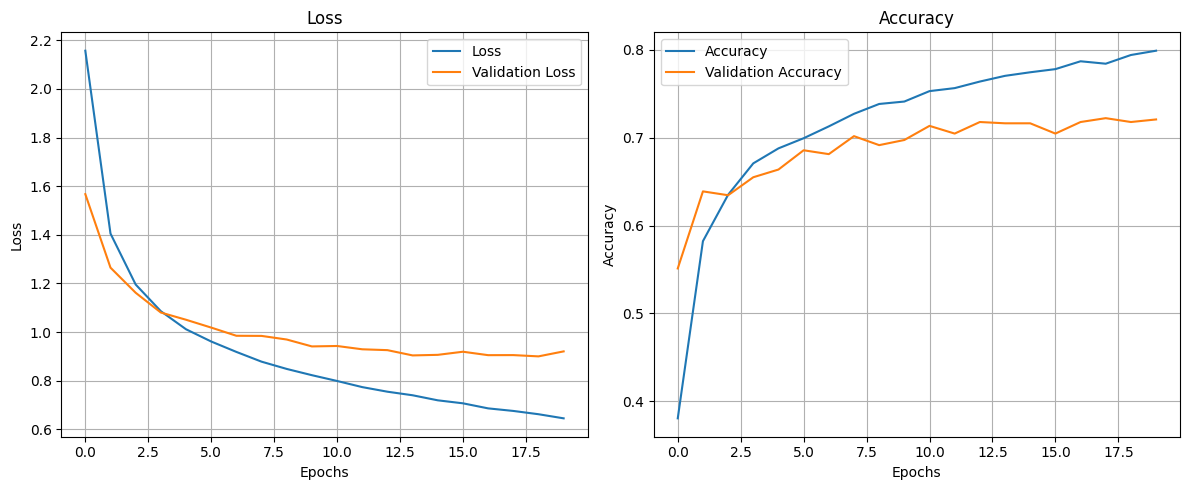

In [485]:
# loss와 validation loss, acc와 validation acc 시각화

draw_history(history_RA_transfer)

In [486]:
# evaluate

eval_transfer = model_RA_transfer.evaluate(X_test_seq_LA, y_test_seq_LA)

'''
    이전보다 좋지 못한 acc를 보이고 있으므로, 아래와 같은 방법을 생각할 수 있겠다.
    
    1) 모든 layer의 trainable을 True로 바꾸어 공평히 weight를 계산하도록 update해줘야 할 것 같다. 
    2) LSTM을 하나 더 추가한다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7004 - loss: 0.9127


'\n    이전보다 좋지 못한 acc를 보이고 있으므로, 아래와 같은 방법을 생각할 수 있겠다.\n    \n    1) 모든 layer의 trainable을 True로 바꾸어 공평히 weight를 계산하도록 update해줘야 할 것 같다. \n    2) LSTM을 하나 더 추가한다.\n'

#### fine-tuning : (5-1) 모든 layer의 trainable을 True로 바꾸어 다시 학습을 진행

- 이러면 이전 모델의 가중치가 다시 LA에 맞춰지도록 train되는 것이다.
- 하지만 RA 학습 후에 LA 학습하는 것이기 때문에, LA에게 모델이 맞추어져 이번에는 RA를 분류하지 못할 가능성이 있다. (추후 evaluate로 확인 예정)

In [487]:
# 이전에 modelRA에서의 layer 중 LSTM의 trainable을 False로 바꾼 것을 번복. 다시 True로 구성
# 구성 후 modeling

base_model.layers[0].trainable = True 

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (trainable)
x = Dense(64, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # RA 데이터셋에 맞는 출력 레이어

model_RA_transfer = Model(inputs=input_data, outputs=output)

# compile
model_RA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [488]:
# layers 시각화, trainable 시각화, model summary

model_RA_transfer.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in model_RA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)     │ (None, 3, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,187 (403.07 KB)

 Trainable params: 103,187 (403.07 KB)

 Non-trainable params: 0 (0.00 B)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_65, built=True>",input_layer_65,True
1,"<LSTM name=lstm_34, built=True>",lstm_34,True
2,"<Dense name=dense_107, built=True>",dense_107,True
3,"<Dense name=dense_108, built=True>",dense_108,True


In [489]:
# fit

history_RA_transfer = model_RA_transfer.fit(X_train_seq_LA, y_train_seq_LA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3653 - loss: 2.1937 - val_accuracy: 0.7266 - val_loss: 0.9426
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7893 - loss: 0.7660 - val_accuracy: 0.8202 - val_loss: 0.6989
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8581 - loss: 0.5183 - val_accuracy: 0.8509 - val_loss: 0.5827
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8994 - loss: 0.3836 - val_accuracy: 0.8655 - val_loss: 0.5641
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9142 - loss: 0.3259 - val_accuracy: 0.8553 - val_loss: 0.5484
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9266 - loss: 0.2663 - val_accuracy: 0.8655 - val_loss: 0.5126
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9422 - loss: 0.2212 - val_accuracy: 0.8728 - val_loss: 0.5241
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9506 - loss: 0.1840 - val_accuracy: 0.

In [490]:
# evaluate (LA)

eval_transfer = model_RA_transfer.evaluate(X_test_seq_LA, y_test_seq_LA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8975 - loss: 0.5101


In [491]:
# evaluate (RA)

eval_transfer = model_RA_transfer.evaluate(X_test_seq_RA, y_test_seq_RA)

'''
    LA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 RA에 대한 acc가 추락이 되었다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3075 - loss: 4.3930


'\n    LA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 RA에 대한 acc가 추락이 되었다.\n'

#### fine-tuning : (5-2) LSTM 층을 하나 더 추가하여 LA의 특성 또한 파악할 수 있게끔 구현


In [492]:
# 이전에 model_RA에서의 layer 중 LSTM의 trainable을 다시 False로 구성 -> LSTM층 추가
# 구성 후 modeling

base_model.layers[0].trainable = False  # 다시 동결 

input_data = tf.keras.Input(shape=(n_timesteps, n_features))

'''
    이전 model에서 return_sequences=True를 설정할 수 없어,
    RepeatVector를 사용하여 LSTM으로부터 출력된 2차원 데이터를 3차원 데이터로 재구성한다.
'''

x = base_model.layers[0](input_data)  # LSTM 레이어 호출 (non trainable)
x = tf.keras.layers.RepeatVector(n_timesteps)(x)  # Reshape output to 3D for LSTM
x = LSTM(32, activation='tanh', return_sequences=False)(x)  # LSTM 새로 추가
x = Dense(32, activation='relu')(x)  # 기존 모델 + 새로운 Dense
output = Dense(n_outputs, activation='softmax')(x)  # LA 데이터셋에 맞는 출력 레이어

model_RA_transfer = tf.keras.Model(inputs=input_data, outputs=output)

# compile
model_RA_transfer.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])


In [493]:
# layers 시각화, trainable 시각화, model summary

model_RA_transfer.summary()

display_layers = [(layer, layer.name, layer.trainable) for layer in model_RA_transfer.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 3, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 128)            │        93,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 19)             │           627 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,987 (453.07 KB)

 Trainable params: 22,291 (87.07 KB)

 Non-trainable params: 93,696 (366.00 KB)

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_66, built=True>",input_layer_66,True
1,"<LSTM name=lstm_34, built=True>",lstm_34,False
2,"<RepeatVector name=repeat_vector_10, built=True>",repeat_vector_10,True
3,"<LSTM name=lstm_37, built=True>",lstm_37,True
4,"<Dense name=dense_109, built=True>",dense_109,True
5,"<Dense name=dense_110, built=True>",dense_110,True


In [494]:
# fit

history_RA_transfer = model_RA_transfer.fit(X_train_seq_LA, y_train_seq_LA, 
                         epochs = 20, batch_size = 32, 
                         validation_split = 0.1, shuffle = True)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3638 - loss: 2.2636 - val_accuracy: 0.8333 - val_loss: 0.7081
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9155 - loss: 0.3982 - val_accuracy: 0.8553 - val_loss: 0.5893
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9512 - loss: 0.2030 - val_accuracy: 0.8553 - val_loss: 0.6009
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9748 - loss: 0.1155 - val_accuracy: 0.8553 - val_loss: 0.6006
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9813 - loss: 0.0832 - val_accuracy: 0.8553 - val_loss: 0.6236
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9909 - loss: 0.0539 - val_accuracy: 0.8480 - val_loss: 0.6856
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9937 - loss: 0.0381 - val_accuracy: 0.8611 - val_loss: 0.6771
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0259 - val_accuracy: 0.

In [495]:
# evaluate (RA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_RA, y_test_seq_RA)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8572 - loss: 0.8804


In [496]:
# evaluate (LA)

eval_transfer = model_LA_transfer.evaluate(X_test_seq_LA, y_test_seq_LA)

'''
    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.
'''

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2896 - loss: 5.0677


'\n    RA에 맞게끔 학습을 진행하였으니, 이번에는 반대로 LA에 대한 acc가 추락이 되었다.\n'